In [ ]:
from pathlib import Path

ROOT = Path(globals()['__vsc_ipynb_file__']).parent.parent
print(ROOT)

import sys
sys.path.append(str(ROOT))

In [2]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import ClassicalRegister

from src.step_1 import get_backend

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.providers.backend import BackendV2
from qiskit.circuit.library import n_local, iSwapGate


import numpy as np


In [3]:
from doe import doe_he

from src.step_1 import get_backend

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.providers.backend import BackendV2
from qiskit.circuit.library import n_local, iSwapGate


import numpy as np

In [ ]:
doe_he['1/scaling/he1rep_piby3_AerSimulator_0.1']

In [6]:
num_qubits = 15 # the number of bonds
device = doe_he['1/scaling/he1rep_piby3_AerSimulator_0.1']['device']
instance = ''
num_vars = num_qubits
ansatz_params = doe_he['1/scaling/he1rep_piby3_AerSimulator_0.1']['ansatz_params']
ansatz = doe_he['1/scaling/he1rep_piby3_AerSimulator_0.1']['ansatz']
theta_initial = doe_he['1/scaling/he1rep_piby3_AerSimulator_0.1']['theta_initial']

backend = get_backend(device, instance, num_vars)
if 'from_backend' in ansatz_params:
    build_backend = get_backend(ansatz_params['from_backend'], instance, num_vars)
else:
    build_backend = backend
backend

def make_iswap_like_block():
    """Creates a 2-qubit iSWAP-like parameterized gate."""

    qc_params = ParameterVector(name='p', length=1)
    qc = QuantumCircuit(2)

    qc.rxx(-qc_params[0]/2, 0, 1)
    qc.ryy(-qc_params[0]/2, 0, 1)

    return qc

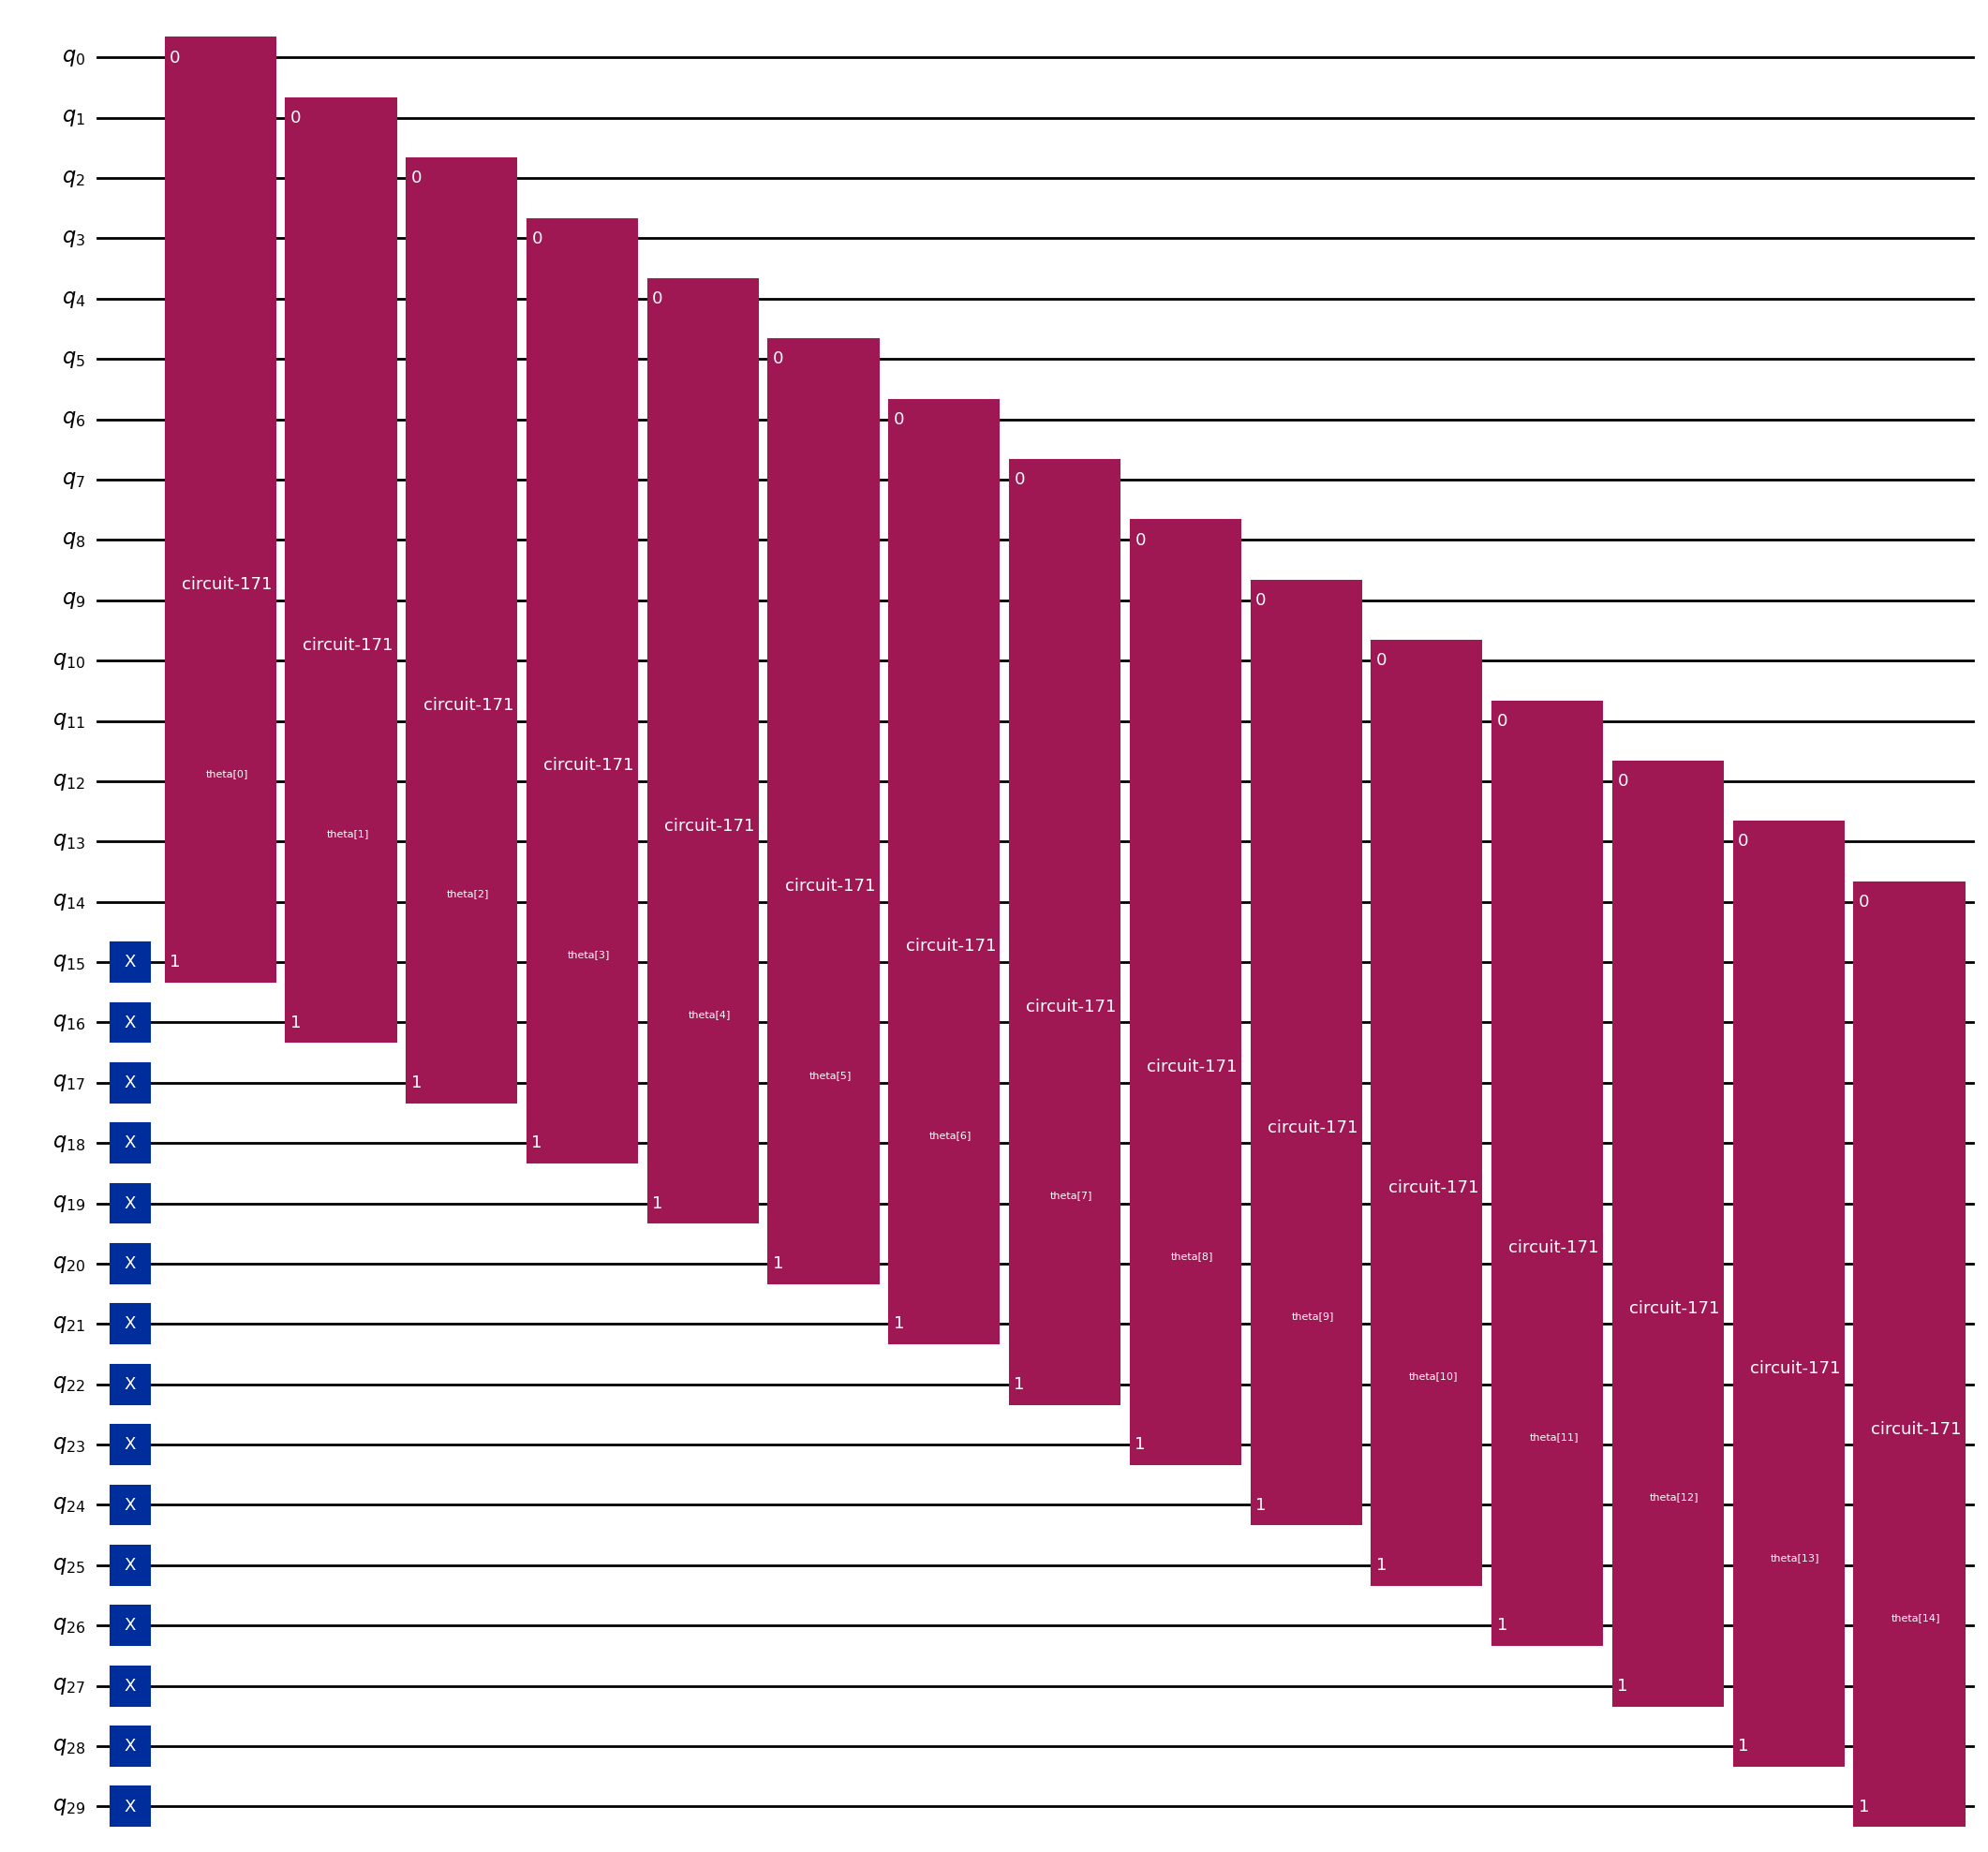

In [7]:
total_qubits = 2 * num_qubits  # problem + bath
iswap_block = make_iswap_like_block()

entangler_map = [[i, num_qubits + i] for i in range(num_qubits)]

init_circ = QuantumCircuit(total_qubits)

# Set bath qubits (second half) to |1⟩
for i in range(num_qubits, total_qubits):
    init_circ.x(i)

# Build HE ansatz
heansatz_ = n_local(
    num_qubits=total_qubits,
    rotation_blocks=[],
    entanglement_blocks=iswap_block.to_gate(),
    entanglement=entangler_map,
    reps=1,
    skip_final_rotation_layer=True,
    overwrite_block_parameters=True,
    parameter_prefix='theta'
)
ansatz_ = init_circ.compose(heansatz_)
# ansatz_.measure_all()
ansatz_.draw('mpl', fold=-1,)

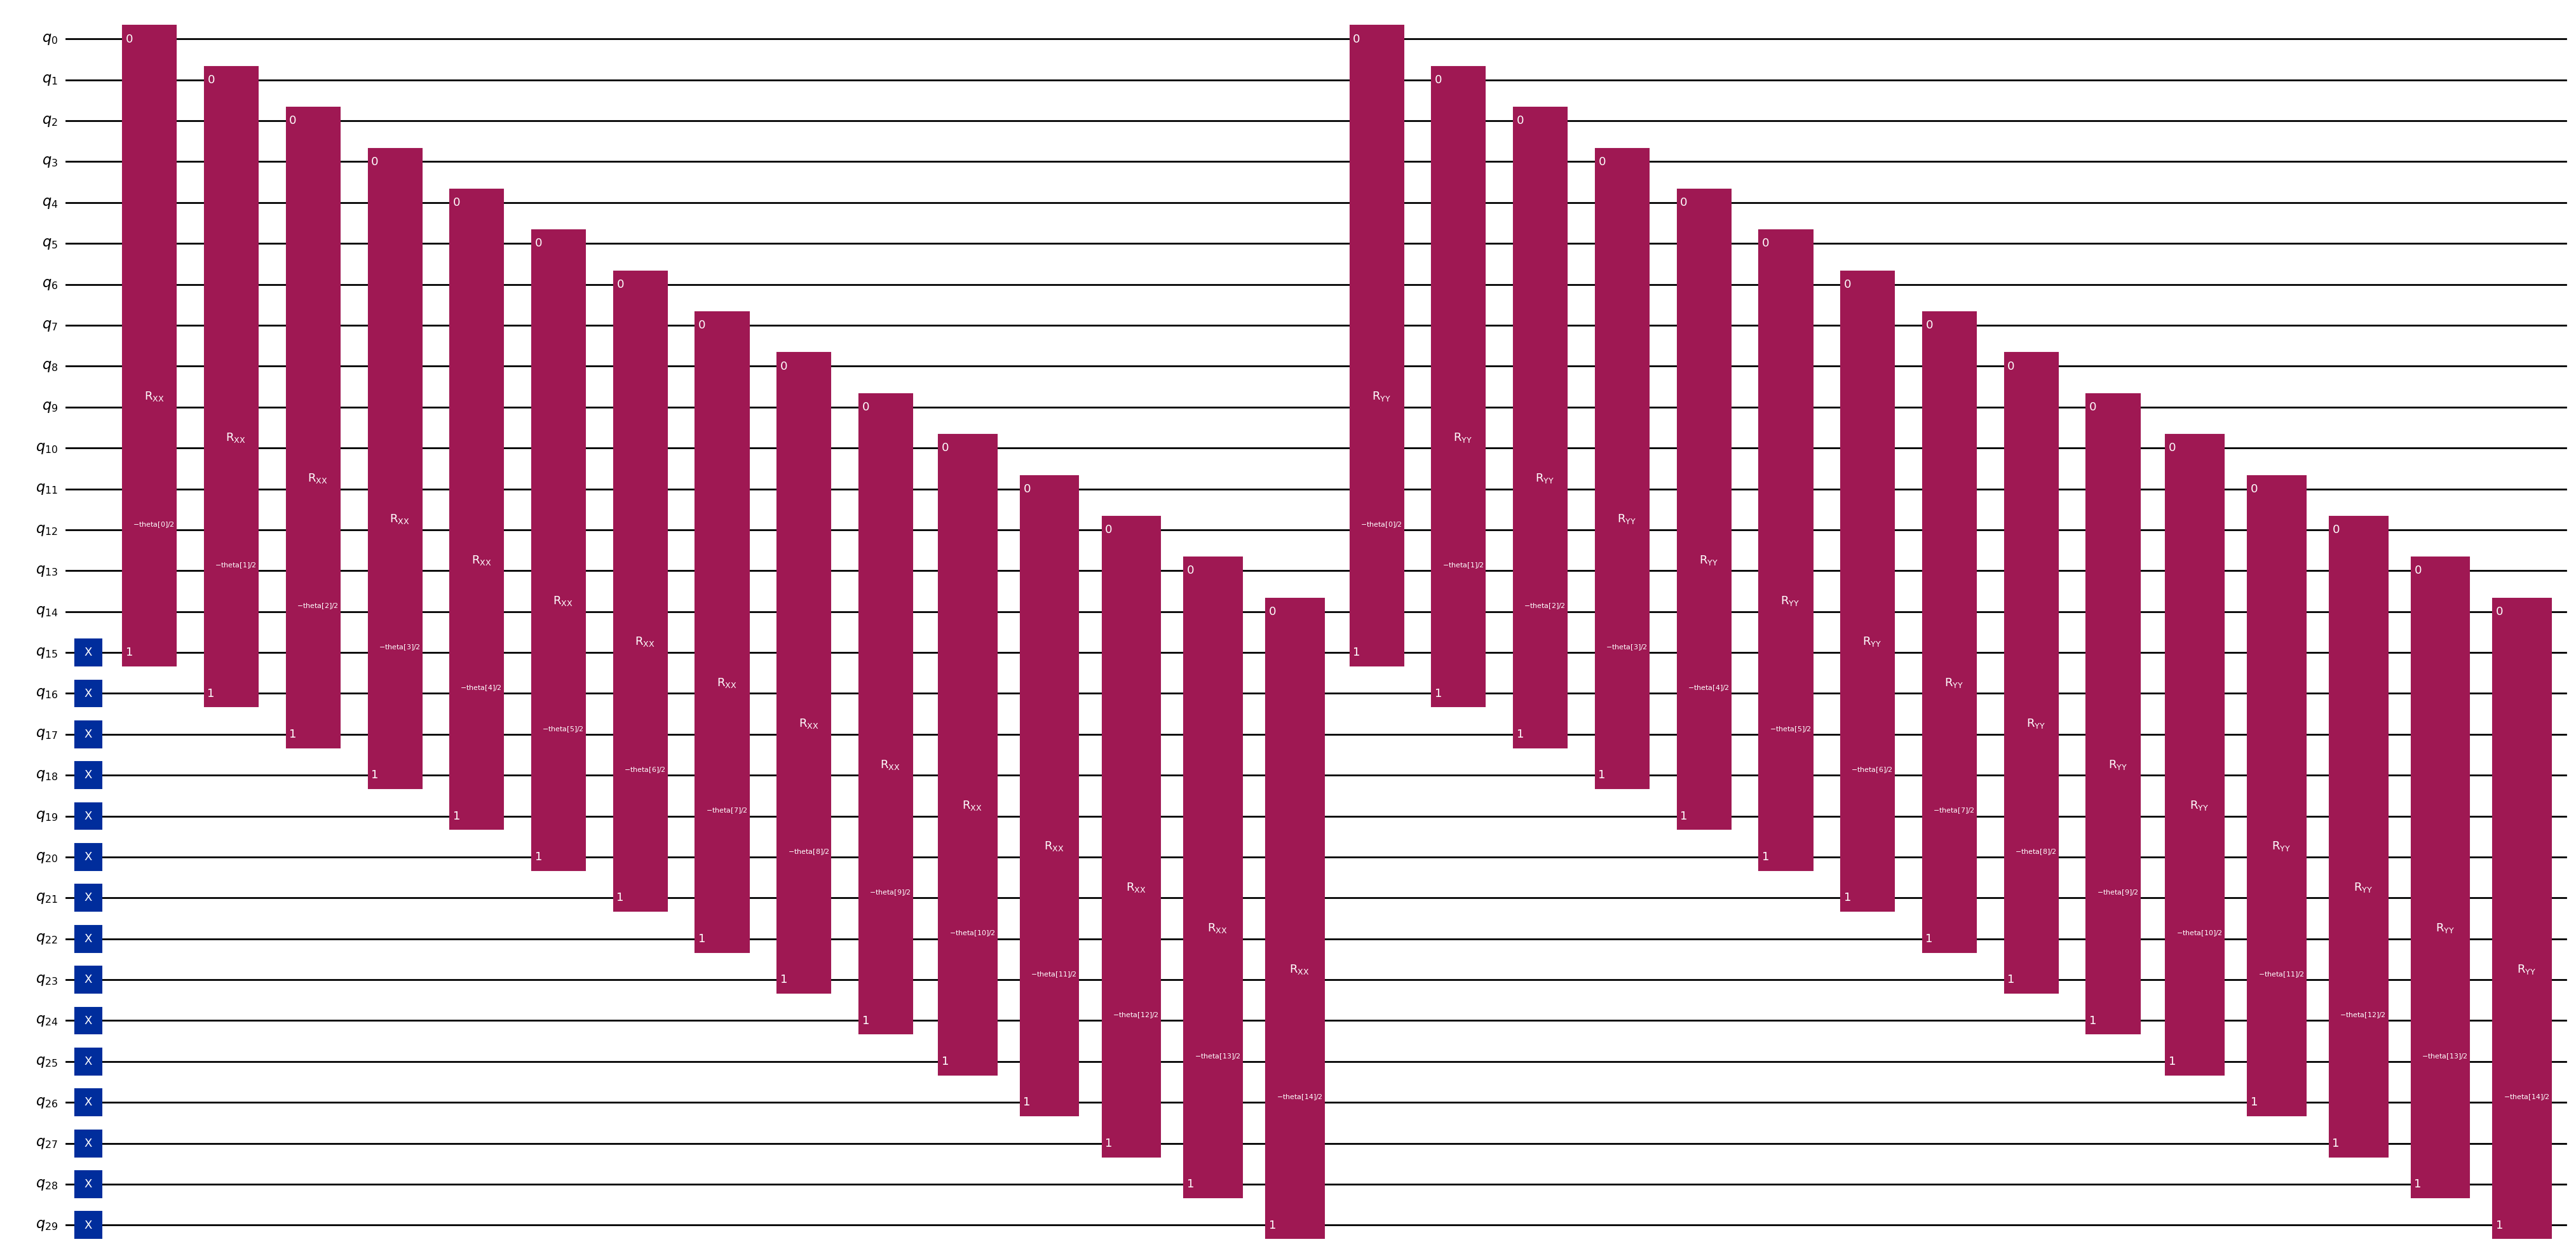

In [8]:
isa_ansatz_ = generate_preset_pass_manager(target=backend.target, optimization_level=0, initial_layout=None).run(ansatz_)
isa_ansatz_.draw('mpl', fold=-1,)

In [9]:
creg = ClassicalRegister(15)
isa_ansatz_.add_register(creg)
isa_ansatz_.measure(list(range(15)),list(range(15)))

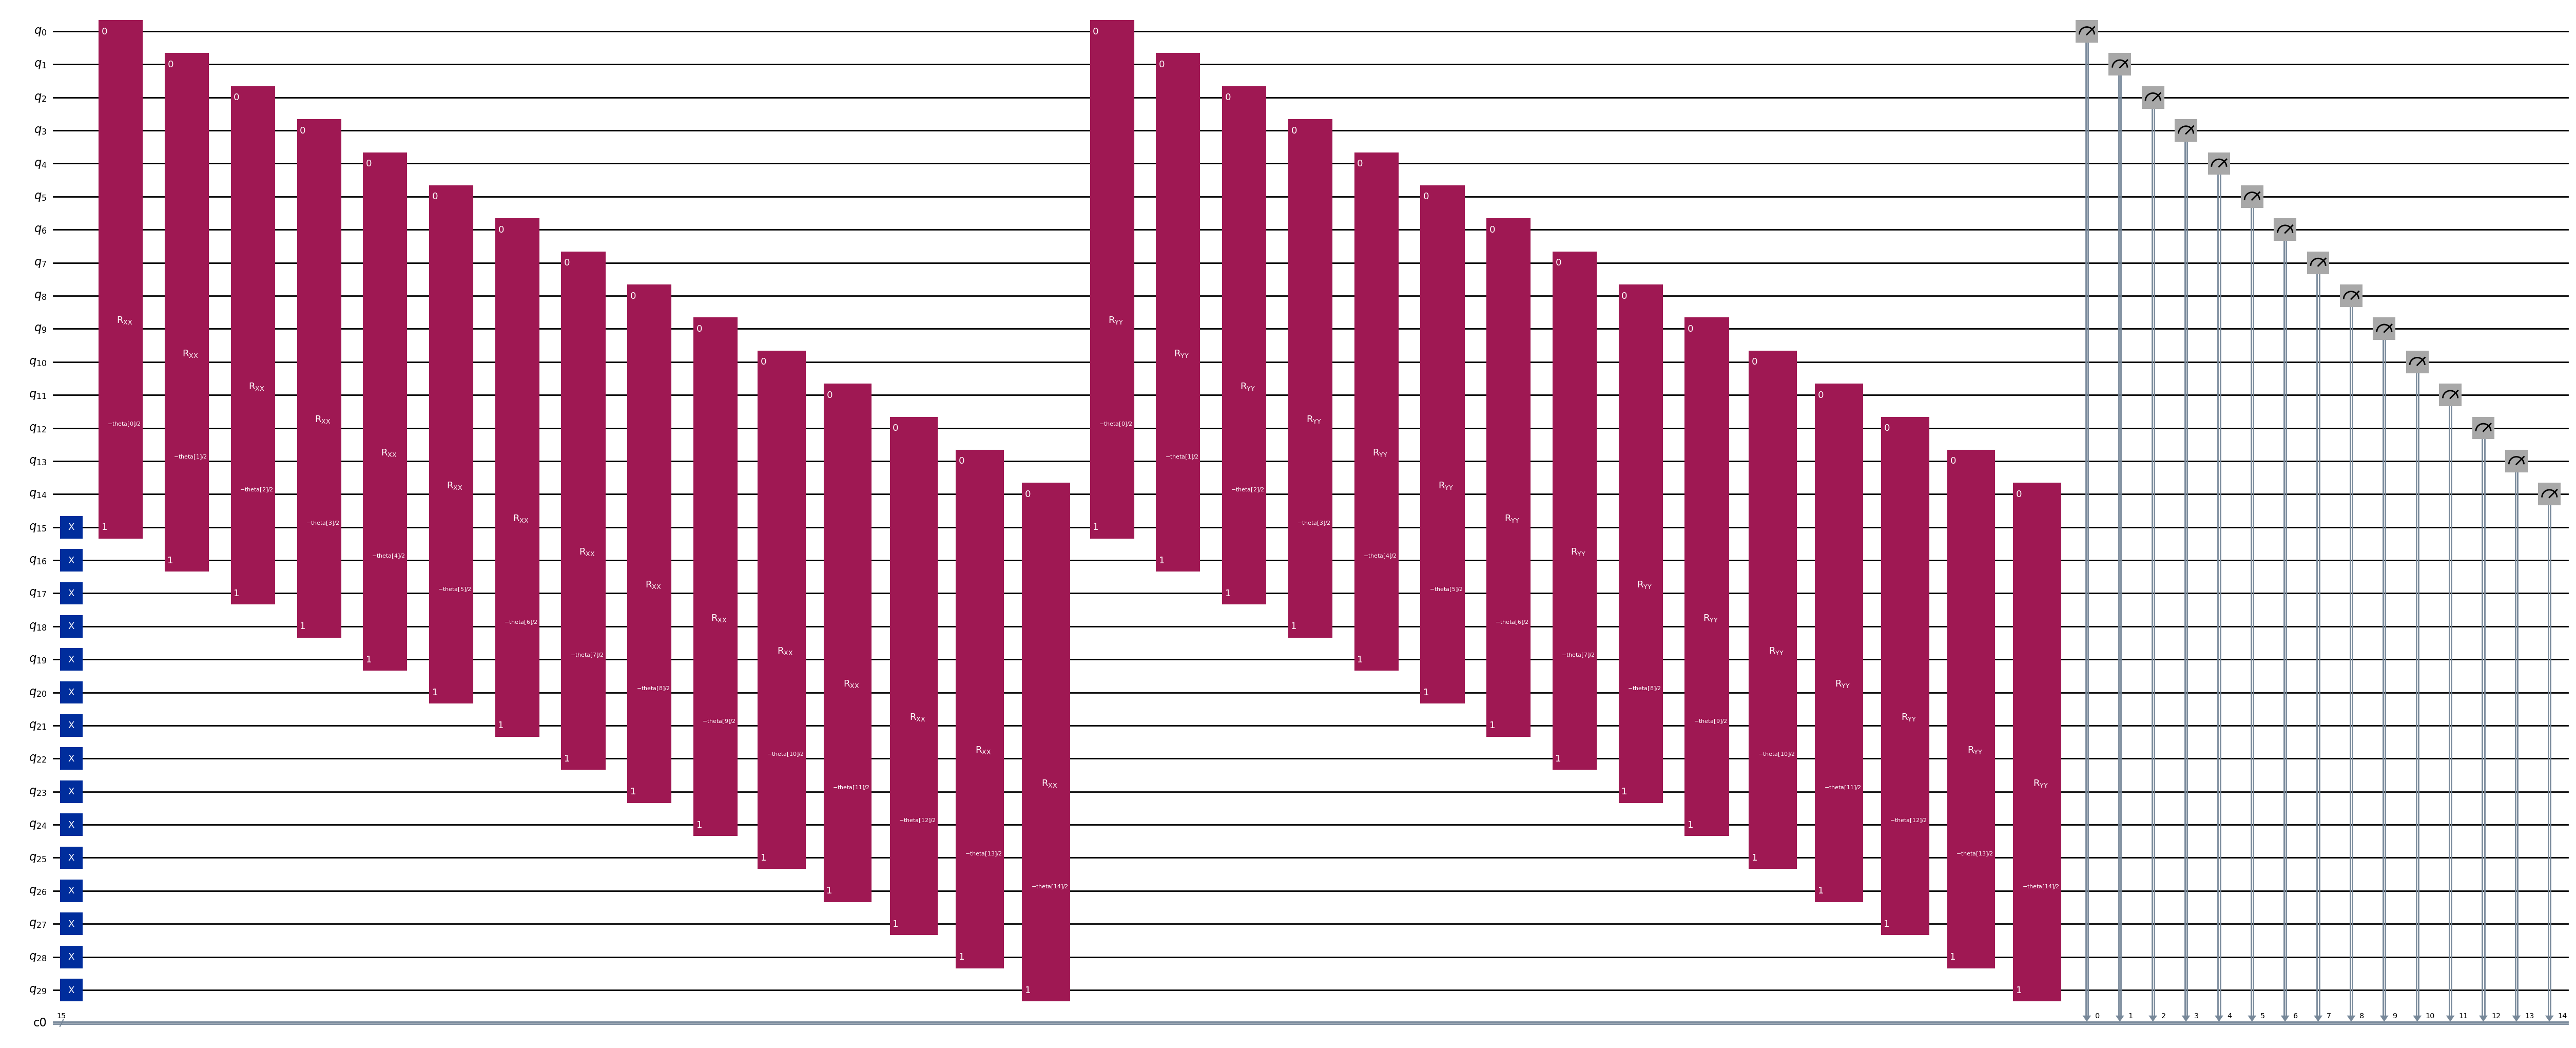

In [10]:
isa_ansatz_.draw('mpl', fold=-1)